# Tensors and computations

In [86]:
import pickle
import numpy as np
import networkx as nx
import scipy
import matplotlib.pyplot as plt
from itertools import product, permutations
from collections import defaultdict
from copy import copy

import scienceplots

plt.style.use(['science'])

from useful_functions import *

In [82]:
def labels_to_integers(dictionary):
    
    labels = {}
    relabeled_dictionary = {}
    
    i = 0
    for edge, (in_edge, out_edge) in dictionary.items():
        
        # Add nodes to the dictionary, if not already there
        for node in in_edge + out_edge:
            if node not in labels.keys():
                labels[node] = i
                i += 1
        
        # Fill the new dictionary
        in_relabeled = [labels[node] for node in in_edge]
        out_relabeled = [labels[node] for node in out_edge]
        
        relabeled_dictionary[edge] = (in_relabeled, out_relabeled)
    
    return labels, relabeled_dictionary

In [83]:
def directed_tensor(dictionary, N):
    
    L = len(list(dictionary.values())[0][0] + list(dictionary.values())[0][1])

    tensor_dict = defaultdict(lambda: 0)

    for in_edge, out_edge in dictionary.values():
        
        for out_node in out_edge:
            
            for in_nodes in set(permutations(in_edge)):
                
                indices = tuple([in_node for in_node in in_nodes] + [out_node])
                
                tensor_dict[indices] += 1
        
    return dict(tensor_dict), tuple([N]*L)

## Astrochem

In [4]:
with open('ProcessedHypergraphs/astrochem2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [5]:
labels, relabeled_dictionary = labels_to_integers(restricted_hyperedges)

In [6]:
T = directed_tensor(relabeled_dictionary, len(labels))

In [7]:
T

({(0, 0, 1): 1,
  (2, 3, 4): 1,
  (3, 2, 4): 1,
  (4, 5, 6): 1,
  (5, 4, 6): 1,
  (4, 5, 3): 1,
  (5, 4, 3): 1,
  (7, 4, 8): 1,
  (4, 7, 8): 1,
  (7, 4, 3): 1,
  (4, 7, 3): 1,
  (4, 9, 0): 1,
  (9, 4, 0): 1,
  (4, 9, 3): 1,
  (9, 4, 3): 1,
  (10, 4, 11): 1,
  (4, 10, 11): 1,
  (10, 4, 3): 1,
  (4, 10, 3): 1,
  (12, 4, 13): 1,
  (4, 12, 13): 1,
  (12, 4, 3): 1,
  (4, 12, 3): 1,
  (14, 4, 15): 1,
  (4, 14, 15): 1,
  (14, 4, 3): 1,
  (4, 14, 3): 1,
  (4, 16, 17): 1,
  (16, 4, 17): 1,
  (4, 16, 3): 1,
  (16, 4, 3): 1,
  (18, 4, 19): 1,
  (4, 18, 19): 1,
  (18, 4, 3): 1,
  (4, 18, 3): 1,
  (4, 20, 21): 1,
  (20, 4, 21): 1,
  (4, 20, 3): 1,
  (20, 4, 3): 1,
  (4, 22, 1): 1,
  (22, 4, 1): 1,
  (4, 22, 0): 1,
  (22, 4, 0): 1,
  (4, 22, 3): 1,
  (22, 4, 3): 1,
  (23, 4, 0): 1,
  (4, 23, 0): 1,
  (23, 4, 24): 1,
  (4, 23, 24): 1,
  (23, 4, 3): 1,
  (4, 23, 3): 1,
  (8, 5, 7): 1,
  (5, 8, 7): 1,
  (8, 5, 6): 1,
  (5, 8, 6): 1,
  (5, 11, 10): 1,
  (11, 5, 10): 1,
  (5, 11, 6): 1,
  (11, 5, 6): 1,


In [8]:
cent, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

HEC = {}
for i, c in enumerate(cent):
    HEC[i] = c 

Finished in 10 iterations.


In [9]:
topN(HEC, N=10)

{2: 0.0066275054315635944,
 6: 0.005175876931867682,
 5: 0.005124671498379,
 17: 0.005019238185003913,
 9: 0.004919551533567627,
 13: 0.00475975271461048,
 22: 0.0047588220613814375,
 23: 0.004528496230775676,
 404: 0.00448133647817626,
 407: 0.004398280563061755}

In [10]:
EC = nx.eigenvector_centrality_numpy(standard_network(relabeled_dictionary))

In [11]:
topN(EC, N=10)

{0: 0.33748719166933955,
 1: 0.2954323390323101,
 24: 0.23737342711203577,
 6: 0.20393682922365172,
 101: 0.19761124153863607,
 17: 0.17547709590841695,
 51: 0.16784940477948324,
 23: 0.13848914450910663,
 19: 0.13022786940901,
 119: 0.11292728218468479}

In [12]:
DC = tensor_in_degree_centrality(T)
topN(DC, N=10)

{0: 3966,
 1: 1755,
 24: 727,
 6: 512,
 17: 383,
 101: 380,
 19: 321,
 51: 316,
 79: 265,
 23: 244}

In [13]:
scipy.stats.kendalltau(list(EC.values()), list(HEC.values())).statistic

0.34720878709395575

In [14]:
KendalltopK_HE = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(HEC, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_HE.append(coeff)

KendalltopK_EH = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH.append(coeff)


In [15]:
KendalltopK_HE_astro = copy(KendalltopK_HE)
KendalltopK_EH_astro = copy(KendalltopK_EH)

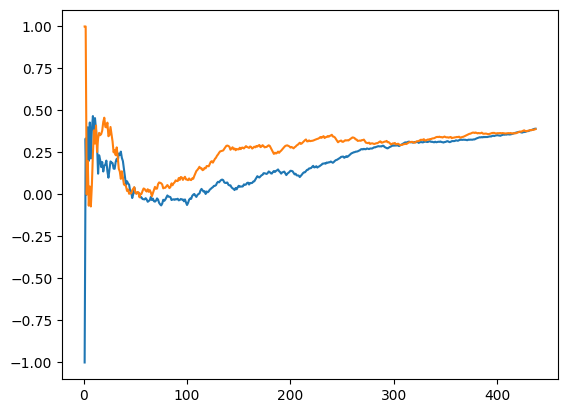

In [16]:
plt.plot(KendalltopK_HE)
plt.plot(KendalltopK_EH)

## KIDA surface

In [17]:
with open('ProcessedHypergraphs/KIDA_surface2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [18]:
labels, relabeled_dictionary = labels_to_integers(restricted_hyperedges)

In [19]:
T = directed_tensor(relabeled_dictionary, len(labels))

In [20]:
T

({(0, 1, 2): 1,
  (1, 0, 2): 1,
  (0, 1, 3): 1,
  (1, 0, 3): 1,
  (4, 0, 2): 1,
  (0, 4, 2): 1,
  (2, 4, 0): 2,
  (4, 2, 0): 2,
  (2, 4, 5): 2,
  (4, 2, 5): 2,
  (4, 4, 5): 1,
  (4, 6, 7): 2,
  (6, 4, 7): 2,
  (4, 6, 5): 2,
  (6, 4, 5): 2,
  (8, 4, 5): 2,
  (4, 8, 5): 2,
  (8, 4, 9): 2,
  (4, 8, 9): 2,
  (4, 10, 11): 1,
  (10, 4, 11): 1,
  (12, 4, 13): 1,
  (4, 12, 13): 1,
  (4, 1, 3): 2,
  (1, 4, 3): 2,
  (4, 1, 5): 2,
  (1, 4, 5): 2,
  (4, 9, 8): 1,
  (9, 4, 8): 1,
  (3, 4, 1): 1,
  (4, 3, 1): 1,
  (7, 4, 6): 2,
  (4, 7, 6): 2,
  (5, 0, 2): 2,
  (0, 5, 2): 2,
  (5, 0, 4): 2,
  (0, 5, 4): 2,
  (4, 11, 10): 2,
  (11, 4, 10): 2,
  (4, 11, 5): 2,
  (11, 4, 5): 2,
  (0, 0, 14): 1,
  (4, 15, 14): 1,
  (15, 4, 14): 1,
  (14, 4, 15): 2,
  (4, 14, 15): 2,
  (14, 4, 5): 2,
  (4, 14, 5): 2,
  (13, 4, 16): 2,
  (4, 13, 16): 2,
  (13, 4, 12): 2,
  (4, 13, 12): 2,
  (13, 4, 5): 2,
  (4, 13, 5): 2,
  (4, 16, 17): 1,
  (16, 4, 17): 1,
  (4, 17, 16): 2,
  (17, 4, 16): 2,
  (4, 17, 5): 2,
  (17, 4, 5)

In [21]:
cent, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

HEC = {}
for i, c in enumerate(cent):
    HEC[i] = c 

Finished in 13 iterations.


In [22]:
topN(HEC, N=10)

{4: 0.10156615689109909,
 17: 0.06795217585764006,
 0: 0.06155732064976909,
 13: 0.05792762503448287,
 1: 0.056333108851976225,
 2: 0.05612382665165112,
 6: 0.05298636221294579,
 5: 0.05285660238421904,
 8: 0.05121302715495265,
 11: 0.05121302715495265}

In [23]:
EC = nx.eigenvector_centrality_numpy(standard_network(relabeled_dictionary))

In [24]:
topN(EC, N=10)

{5: 0.5856039149141046,
 2: 0.4006511674269648,
 4: 0.2672162812585443,
 0: 0.2559637469764555,
 3: 0.21470901741343307,
 14: 0.21470901741343307,
 8: 0.1731455600170662,
 16: 0.1682231616993533,
 15: 0.15302190422365086,
 1: 0.1530219042236507}

In [25]:
DC = tensor_in_degree_centrality(T)
topN(DC, N=10)

{5: 37, 2: 8, 0: 8, 16: 8, 3: 6, 8: 6, 7: 4, 9: 4, 6: 4, 4: 4}

In [26]:
scipy.stats.kendalltau(list(EC.values()), list(HEC.values())).statistic

0.2562459173457251

In [27]:
KendalltopK_HE = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(HEC, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_HE.append(coeff)

KendalltopK_EH = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH.append(coeff)


In [28]:
KendalltopK_HE_surface = copy(KendalltopK_HE)
KendalltopK_EH_surface = copy(KendalltopK_EH)

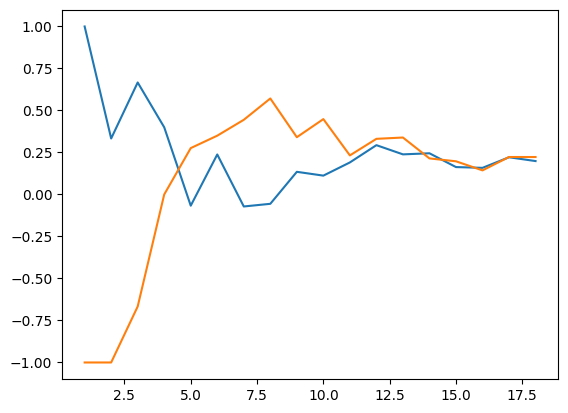

In [29]:
plt.plot(KendalltopK_HE)
plt.plot(KendalltopK_EH)

## KIDA Unibimolecular

In [30]:
with open('ProcessedHypergraphs/KIDA_unibimolecular2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [31]:
labels, relabeled_dictionary = labels_to_integers(restricted_hyperedges)

In [32]:
T = directed_tensor(relabeled_dictionary, len(labels))

In [33]:
T

({(0, 1, 2): 1,
  (1, 0, 2): 1,
  (0, 1, 3): 1,
  (1, 0, 3): 1,
  (0, 1, 4): 1,
  (1, 0, 4): 1,
  (0, 1, 5): 1,
  (1, 0, 5): 1,
  (0, 1, 6): 2,
  (1, 0, 6): 2,
  (1, 7, 6): 1,
  (7, 1, 6): 1,
  (1, 7, 8): 1,
  (7, 1, 8): 1,
  (1, 7, 9): 2,
  (7, 1, 9): 2,
  (1, 7, 10): 1,
  (7, 1, 10): 1,
  (1, 7, 11): 1,
  (7, 1, 11): 1,
  (1, 7, 2): 1,
  (7, 1, 2): 1,
  (1, 7, 12): 1,
  (7, 1, 12): 1,
  (1, 13, 14): 1,
  (13, 1, 14): 1,
  (1, 13, 15): 1,
  (13, 1, 15): 1,
  (1, 16, 2): 2,
  (16, 1, 2): 2,
  (1, 16, 17): 2,
  (16, 1, 17): 2,
  (1, 16, 5): 4,
  (16, 1, 5): 4,
  (1, 16, 18): 2,
  (16, 1, 18): 2,
  (1, 16, 19): 2,
  (16, 1, 19): 2,
  (1, 16, 20): 2,
  (16, 1, 20): 2,
  (1, 16, 21): 2,
  (16, 1, 21): 2,
  (1, 16, 22): 2,
  (16, 1, 22): 2,
  (1, 23, 24): 2,
  (23, 1, 24): 2,
  (1, 23, 5): 2,
  (23, 1, 5): 2,
  (1, 23, 25): 2,
  (23, 1, 25): 2,
  (1, 23, 22): 2,
  (23, 1, 22): 2,
  (1, 23, 26): 2,
  (23, 1, 26): 2,
  (1, 23, 27): 2,
  (23, 1, 27): 2,
  (1, 28, 29): 1,
  (28, 1, 29): 1,
  (1

In [34]:
cent, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

HEC = {}
for i, c in enumerate(cent):
    HEC[i] = c 

Finished in 11 iterations.


In [35]:
topN(HEC, N=10)

{5: 0.006718280836203448,
 350: 0.006220536774983158,
 1: 0.005966407054059328,
 67: 0.005785556201084433,
 34: 0.0054195898662600115,
 62: 0.005363640107158281,
 6: 0.005206591262727915,
 2: 0.005169651161924393,
 84: 0.005048239440090487,
 64: 0.004875871466139945}

In [36]:
EC = nx.eigenvector_centrality_numpy(standard_network(relabeled_dictionary))

In [37]:
topN(EC, N=10)

{2: 0.30118859697570033,
 18: 0.26329750375054467,
 26: 0.20862146398561845,
 34: 0.16958619061260352,
 351: 0.15034786187453578,
 47: 0.14311365179925042,
 22: 0.14287286641000216,
 135: 0.13722065335295594,
 1: 0.1349546305809151,
 123: 0.13320596571721272}

In [38]:
DC = tensor_in_degree_centrality(T)
topN(DC, N=10)

{2: 4507,
 18: 2316,
 26: 1268,
 351: 1018,
 34: 708,
 14: 568,
 22: 511,
 67: 479,
 21: 438,
 9: 407}

In [39]:
scipy.stats.kendalltau(list(EC.values()), list(HEC.values())).statistic

0.5270998662868521

In [40]:
KendalltopK_HE = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(HEC, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_HE.append(coeff)

KendalltopK_EH = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH.append(coeff)


In [41]:
KendalltopK_HE_unibi = copy(KendalltopK_HE)
KendalltopK_EH_unibi = copy(KendalltopK_EH)

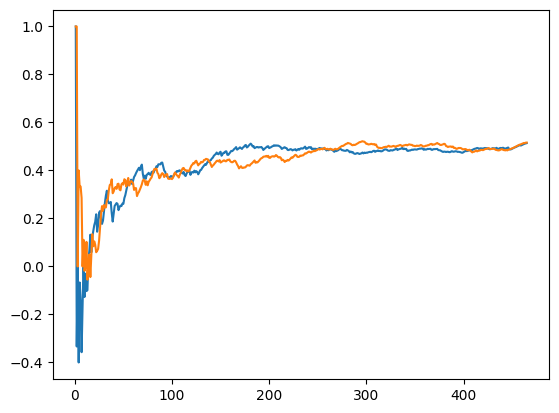

In [42]:
plt.plot(KendalltopK_HE)
plt.plot(KendalltopK_EH)

## KIDA uva

In [43]:
with open('ProcessedHypergraphs/KIDA_uva2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [44]:
labels, relabeled_dictionary = labels_to_integers(restricted_hyperedges)

In [45]:
T = directed_tensor(relabeled_dictionary, len(labels))

In [46]:
T

({(0, 1, 2): 1,
  (1, 0, 2): 1,
  (0, 1, 3): 1,
  (1, 0, 3): 1,
  (0, 1, 4): 1,
  (1, 0, 4): 1,
  (0, 1, 5): 1,
  (1, 0, 5): 1,
  (0, 1, 6): 2,
  (1, 0, 6): 2,
  (1, 7, 6): 1,
  (7, 1, 6): 1,
  (1, 7, 8): 1,
  (7, 1, 8): 1,
  (1, 7, 9): 2,
  (7, 1, 9): 2,
  (1, 7, 10): 1,
  (7, 1, 10): 1,
  (1, 7, 11): 1,
  (7, 1, 11): 1,
  (1, 7, 2): 1,
  (7, 1, 2): 1,
  (1, 7, 12): 1,
  (7, 1, 12): 1,
  (1, 13, 14): 1,
  (13, 1, 14): 1,
  (1, 13, 15): 1,
  (13, 1, 15): 1,
  (1, 16, 17): 1,
  (16, 1, 17): 1,
  (1, 16, 18): 1,
  (16, 1, 18): 1,
  (1, 16, 19): 1,
  (16, 1, 19): 1,
  (1, 16, 5): 2,
  (16, 1, 5): 2,
  (1, 16, 20): 1,
  (16, 1, 20): 1,
  (1, 16, 21): 1,
  (16, 1, 21): 1,
  (1, 16, 2): 1,
  (16, 1, 2): 1,
  (1, 16, 22): 1,
  (16, 1, 22): 1,
  (1, 23, 24): 1,
  (23, 1, 24): 1,
  (1, 23, 21): 1,
  (23, 1, 21): 1,
  (1, 23, 25): 1,
  (23, 1, 25): 1,
  (1, 23, 26): 1,
  (23, 1, 26): 1,
  (1, 23, 27): 1,
  (23, 1, 27): 1,
  (1, 23, 5): 1,
  (23, 1, 5): 1,
  (1, 28, 17): 2,
  (28, 1, 17): 2,
  (1

In [47]:
cent, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

HEC = {}
for i, c in enumerate(cent):
    HEC[i] = c 

Finished in 10 iterations.


In [48]:
topN(HEC, N=10)

{5: 0.005784472293958557,
 374: 0.005772543602127343,
 1: 0.0049428340248586534,
 74: 0.004937968490899624,
 76: 0.004617406288258616,
 34: 0.004587558589012746,
 79: 0.004524688235014011,
 84: 0.004426608325684354,
 104: 0.004297380344270319,
 2: 0.004294502235370921}

In [49]:
EC = nx.eigenvector_centrality_numpy(standard_network(relabeled_dictionary))

In [50]:
topN(EC, N=10)

{2: 0.2864351176471258,
 17: 0.25025556488380213,
 34: 0.20895378622998917,
 25: 0.20519199565252072,
 14: 0.1712641663060101,
 20: 0.1546954067281763,
 369: 0.1537461988790724,
 79: 0.15055399673352143,
 1: 0.14876936041678698,
 9: 0.1267695821485565}

In [51]:
DC = tensor_in_degree_centrality(T)
topN(DC, N=10)

{2: 5072,
 17: 2284,
 25: 1011,
 369: 1000,
 34: 810,
 14: 568,
 79: 551,
 20: 452,
 90: 421,
 5: 394}

In [52]:
scipy.stats.kendalltau(list(EC.values()), list(HEC.values())).statistic

0.4323477153106038

In [53]:
KendalltopK_HE = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(HEC, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_HE.append(coeff)

KendalltopK_EH = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH.append(coeff)


In [54]:
KendalltopK_HE_uva = copy(KendalltopK_HE)
KendalltopK_EH_uva = copy(KendalltopK_EH)

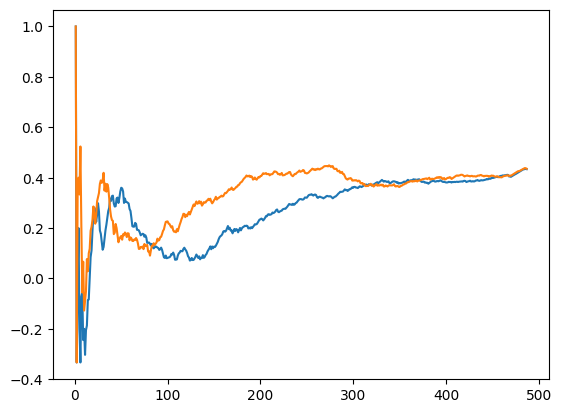

In [55]:
plt.plot(KendalltopK_HE)
plt.plot(KendalltopK_EH)

## Reaction Template Generator

In [56]:
with open('ProcessedHypergraphs/ReactionTemplate2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [57]:
labels, relabeled_dictionary = labels_to_integers(restricted_hyperedges)

In [58]:
T = directed_tensor(relabeled_dictionary, len(labels))

In [59]:
T

({(0, 1, 2): 1,
  (1, 0, 2): 1,
  (0, 1, 3): 1,
  (1, 0, 3): 1,
  (2, 3, 0): 1,
  (3, 2, 0): 1,
  (2, 3, 1): 1,
  (3, 2, 1): 1,
  (2, 4, 0): 1,
  (4, 2, 0): 1,
  (2, 4, 3): 1,
  (4, 2, 3): 1,
  (0, 3, 2): 1,
  (3, 0, 2): 1,
  (0, 3, 4): 1,
  (3, 0, 4): 1,
  (3, 4, 0): 1,
  (4, 3, 0): 1,
  (3, 4, 5): 1,
  (4, 3, 5): 1,
  (5, 0, 3): 1,
  (0, 5, 3): 1,
  (5, 0, 4): 1,
  (0, 5, 4): 1,
  (2, 5, 3): 2,
  (5, 2, 3): 2,
  (3, 3, 2): 1,
  (3, 3, 5): 1,
  (4, 6, 0): 2,
  (6, 4, 0): 2,
  (4, 6, 6): 1,
  (6, 4, 6): 1,
  (1, 6, 2): 2,
  (6, 1, 2): 2,
  (1, 6, 6): 1,
  (6, 1, 6): 1,
  (6, 3, 2): 1,
  (3, 6, 2): 1,
  (6, 3, 0): 1,
  (3, 6, 0): 1,
  (6, 3, 6): 1,
  (3, 6, 6): 1,
  (5, 6, 0): 1,
  (6, 5, 0): 1,
  (5, 6, 3): 1,
  (6, 5, 3): 1,
  (5, 6, 6): 1,
  (6, 5, 6): 1,
  (4, 1, 0): 1,
  (1, 4, 0): 1,
  (4, 1, 7): 1,
  (1, 4, 7): 1,
  (0, 7, 4): 1,
  (7, 0, 4): 1,
  (0, 7, 1): 1,
  (7, 0, 1): 1,
  (2, 7, 3): 1,
  (7, 2, 3): 1,
  (2, 7, 1): 1,
  (7, 2, 1): 1,
  (3, 1, 7): 1,
  (1, 3, 7): 1,
  (3, 1,

In [60]:
cent, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

HEC = {}
for i, c in enumerate(cent):
    HEC[i] = c 

Finished in 9 iterations.


In [61]:
topN(HEC, N=10)

{3: 0.033692274928092555,
 0: 0.03237099998310089,
 2: 0.03091880008879505,
 12: 0.02847678893791191,
 1: 0.028380038897893367,
 11: 0.02830830743197469,
 9: 0.027113715555434553,
 7: 0.026655183611131155,
 14: 0.02618630182932014,
 4: 0.02449164019683175}

In [62]:
EC = nx.eigenvector_centrality_numpy(standard_network(relabeled_dictionary))

In [63]:
topN(EC, N=10)

{0: 0.3288248953594505,
 3: 0.3138563831723038,
 2: 0.2504930933938994,
 12: 0.23683339168971407,
 11: 0.23018350023152687,
 14: 0.2293026026815807,
 9: 0.2244995442524014,
 37: 0.2092958515600238,
 32: 0.20627525612244205,
 4: 0.19164750814743092}

In [64]:
DC = tensor_in_degree_centrality(T)
topN(DC, N=10)

{0: 137, 3: 114, 9: 88, 2: 65, 14: 61, 12: 56, 1: 48, 11: 45, 4: 41, 32: 36}

In [65]:
scipy.stats.kendalltau(list(EC.values()), list(HEC.values())).statistic

0.60491751494519

In [66]:
KendalltopK_HE = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(HEC, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_HE.append(coeff)

KendalltopK_EH = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH.append(coeff)


In [67]:
KendalltopK_HE_RTG = copy(KendalltopK_HE)
KendalltopK_EH_RTG = copy(KendalltopK_EH)

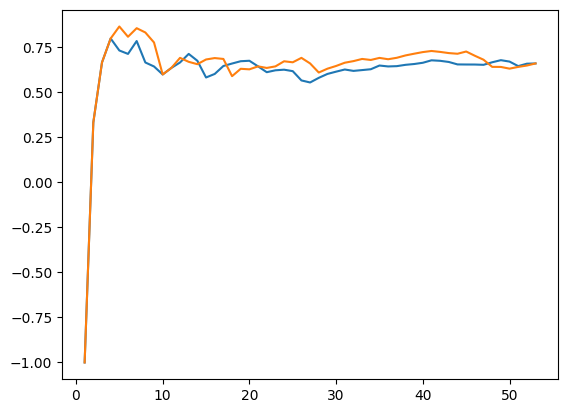

In [68]:
plt.plot(KendalltopK_HE)
plt.plot(KendalltopK_EH)

## All together

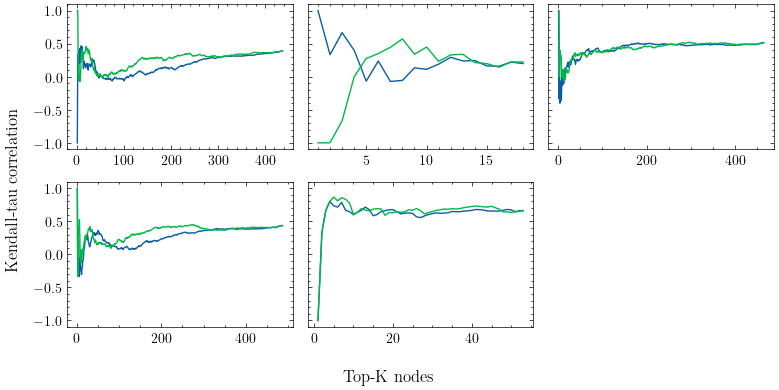

In [90]:
fig, ax = plt.subplots(2,3,figsize=(8,4), sharey=True)

fig.supylabel("Kendall-tau correlation")
fig.supxlabel("Top-K nodes")

ax[0,0].plot(KendalltopK_HE_astro)
ax[0,0].plot(KendalltopK_EH_astro)

ax[0,1].plot(KendalltopK_HE_surface)
ax[0,1].plot(KendalltopK_EH_surface)

ax[0,2].plot(KendalltopK_HE_unibi)
ax[0,2].plot(KendalltopK_EH_unibi)

ax[1,0].plot(KendalltopK_HE_uva)
ax[1,0].plot(KendalltopK_EH_uva)

ax[1,1].plot(KendalltopK_HE_RTG)
ax[1,1].plot(KendalltopK_EH_RTG)

ax[1,2].axis('off')

plt.tight_layout()

plt.savefig("Figures/Kendalltau-TopKs.png")